In [18]:
import ifcb
import csv
from urllib.request import urlopen
import numpy as np
import os
import imageio
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
def create_folders(output_path,classes):
    for folder_name in classes:
        path = output_path + '/' + folder_name
        try:
            Path(path).mkdir(parents=True, exist_ok=True)
        except OSError:
            print ("Creation of the directory %s failed" % path)

In [3]:
def classify_images_in_folders(base_url,output_path,pid,threshold):
    """ Reads dashboard autoclass file and classify images if max score
    is greater than the defined threshold. Images will be moved to the 
    Unclassified folder otherwise.
    """
    # Determine classes list and classes with best score 
    with urlopen(base_url + pid + '_class_scores.csv') as f :
        reader = csv.reader(f.read().decode('utf-8').split('\n'),delimiter=',')
        classes = next(reader)[1:]
        classes.append('Unclassified')
        create_folders(output_path,classes)
        roi_numbers = []
        best_classes = []
        for row in reader:
            if len(row) > 0:
                roi_number = int(row[0].split("_")[-1])
                roi_numbers.append(roi_number)
                scores = [float(score) for score in row[1:]]
                max_score = np.amax(scores)
                if max_score > threshold:
                    best_class = np.where(scores == max_score)[0][0]
                else:
                    best_class = classes.index('Unclassified')
                best_classes.append(best_class)
    
    # Retrieving images 
    with ifcb.open_url(base_url + pid) as sample_bin:
        print('{} has {} image(s)'.format(sample_bin.lid, len(sample_bin.images)))
        results = {k:0 for k in classes}  # Initializing distribution results
        for roi_number in sample_bin.images:
            pos = roi_numbers.index(roi_number)
            best_class = best_classes[pos]
            class_name = classes[best_class]
            results[class_name] = results[class_name] + 1 # Counting images
            img_path = output_path + '/' + class_name + '/' +  pid + '_' + str(roi_number) + '.png'
            imageio.imwrite(img_path, sample_bin.images[roi_number])
        count_matrix = np.array(list(results.items()))
        classes = count_matrix[:,0]
        counts = count_matrix[:,1].astype(int).reshape((1,len(classes)))
    return classes, counts

In [6]:
pids_file = "bins.csv"
base_url = 'https://ifcb-data.whoi.edu/mvco/'
output_dir = 'whoi-data'
threshold = 0.5
n_classes = 146

In [238]:
with open(pids_file) as f:
    reader = csv.reader(f)
    all_counts = np.empty((0,n_classes), int)
    pids = []
    for row in reader:
        pid = row[0]
        pids.append(pid)
        classes, counts = classify_images_in_folders(base_url,output_dir,pid,threshold)
        all_counts = np.append(all_counts,counts,axis=0) # Aggregating counts from all files
print("Images saved in {}".format(output_dir))

D20200608T203418_IFCB010 has 5174 image(s)
D20200608T201224_IFCB010 has 5308 image(s)
D20200608T195031_IFCB010 has 5143 image(s)
D20200608T192838_IFCB010 has 5304 image(s)
D20200608T190645_IFCB010 has 5072 image(s)
Images saved in whoi-data


In [247]:
def plot_distribution(labels, data, classes):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *classes*.
    classes : list of str
        The category labels.
    """
    #labels = list(results.keys())
    #data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    classes_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))
    fig, ax = plt.subplots(figsize=(12, len(labels)*.5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    for i, (colname, color) in enumerate(zip(classes, classes_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.8,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(classes), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    return fig, ax

Number of remaining classes: 19


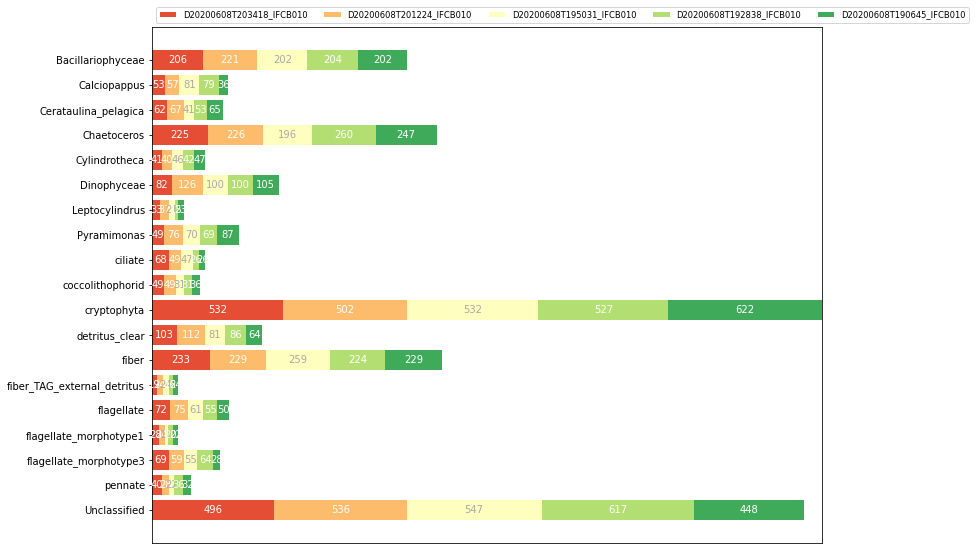

In [250]:
# Filtering classes with low counts
min_counts = 100
k = []
for i,(species,counts) in enumerate(zip(classes,np.transpose(all_counts))):
    if(np.all(counts==0) or np.sum(counts)<min_counts or species in['mix', 'detritus','bead']):
        k.append(i)
t_classes = np.delete(classes,k)
t_all_counts = np.delete(all_counts,k,1)
print("Number of remaining classes: {}".format(len(t_classes)))
plot_distribution(t_classes, np.transpose(t_all_counts), pids)
plt.savefig('count_distribution.jpeg')
plt.show()